In [41]:
from sklearn.utils import murmurhash3_32
import csv
import pandas as pd
from collections import defaultdict, Counter
import random
import matplotlib.pyplot as plt
import numpy as np

In [42]:
data = pd.read_csv("user-ct-test-collection-01.txt", sep="\t")

In [43]:
querylist = data.Query.dropna()

In [44]:
len(querylist)

3558238

In [45]:
dic = defaultdict(int)
for query in querylist:
    for word in query.split():
        dic[word] += 1

In [46]:
counter = Counter(dic)

In [47]:
Freq_100 = counter.most_common(100)
Infreq_100 = counter.most_common()[-100:]

random.seed = 142
samp = random.sample(range(len(counter)), 100)
keys = list(counter.keys())
values = list(counter.values())
Rand_100 = []
for i in samp:
    Rand_100.append((keys[i], values[i]))

In [48]:
class CountMinSketch():
    def __init__(self, R = 2**14, seed = [0, 1, 2, 3, 4]):
        self.d = 5
        self.R = R
        self.cnt = [[0]*self.R for _ in range(self.d)]
        self.top500 = defaultdict(int)
        self.top500_min = float('inf')
        self.top500_minkey = None
        self.seed = seed
    
    def insert(self, key):
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed[i], positive=True) % self.R
            self.cnt[i][hx] += 1
            
        if key in self.top500 or len(self.top500) < 500:
            self.top500[key] = self.query(key)
            if self.top500[key] < self.top500_min:
                self.top500_min = self.top500[key]
                self.top500_minkey = key
                
        elif self.query(key) > self.top500_min:
            del self.top500[self.top500_minkey]
            self.top500[key] = self.query(key)
            self.top500_minkey = min(self.top500, key = self.top500.get)
            self.top500_min = self.top500[self.top500_minkey]
    
    def query(self, key):
        min_count = float('inf')
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed[i], positive=True) % self.R
            min_count = min(min_count, self.cnt[i][hx])
        return min_count
    
    def get_top500(self):
        return self.top500
        

class CountMedianSketch():
    def __init__(self, R = 2**14, seed = [0, 1, 2, 3, 4]):
        self.d = 5
        self.R = R
        self.cnt = [[0]*self.R for _ in range(self.d)]
        self.top500 = defaultdict(int)
        self.top500_min = float('inf')
        self.top500_minkey = None
        self.seed = seed
    
    def insert(self, key):
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed[i], positive=True) % self.R
            self.cnt[i][hx] += 1
            
        if key in self.top500 or len(self.top500) < 500:
            self.top500[key] = self.query(key)
            if self.top500[key] < self.top500_min:
                self.top500_min = self.top500[key]
                self.top500_minkey = key
                
        elif self.query(key) > self.top500_min:
            del self.top500[self.top500_minkey]
            self.top500[key] = self.query(key)
            self.top500_minkey = min(self.top500, key = self.top500.get)
            self.top500_min = self.top500[self.top500_minkey]
    
    def query(self, key):
        cnt = []
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed[i], positive=True) % self.R
            cnt.append(self.cnt[i][hx])
        cnt.sort()
        return cnt[2]
    
    def get_top500(self):
        return self.top500

class CountSketch():
    def __init__(self, R = 2**14, seed_h = [0, 1, 2, 3, 4], seed_g = [6, 7, 8, 9, 10]):
        self.d = 5
        self.R = R
        self.cnt = [[0]*self.R for _ in range(self.d)]
        self.top500 = defaultdict(int)
        self.top500_min = float('inf')
        self.top500_minkey = None
        self.seed_h = seed_h
        self.seed_g = seed_g
    
    def insert(self, key):
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed_h[i], positive=True) % self.R
            gx = murmurhash3_32(key, seed=self.seed_g[i], positive=True) % 2
            if gx == 0:
                gx = -1
            self.cnt[i][hx] += gx
            
        if key in self.top500 or len(self.top500) < 500:
            self.top500[key] = self.query(key)
            if self.top500[key] < self.top500_min:
                self.top500_min = self.top500[key]
                self.top500_minkey = key
                
        elif self.query(key) > self.top500_min:
            del self.top500[self.top500_minkey]
            self.top500[key] = self.query(key)
            self.top500_minkey = min(self.top500, key = self.top500.get)
            self.top500_min = self.top500[self.top500_minkey]
    
    def query(self, key):
        min_count = float('inf')
        for i in range(self.d):
            hx = murmurhash3_32(key, seed=self.seed_h[i], positive=True) % self.R
            gx = murmurhash3_32(key, seed=self.seed_g[i], positive=True) % 2
            if gx == 0:
                gx = -1
            min_count = min(min_count, gx * self.cnt[i][hx])
        return min_count
    
    def get_top500(self):
        return self.top500
        

# R = 2**10

In [49]:
cms = CountMinSketch(R = 2**10)
cmeds = CountMedianSketch(R = 2**10)
cs = CountSketch(R = 2**10)
cnt = 0
for query in querylist:
    for word in query.split():
        cms.insert(word)
        cmeds.insert(word)
        cs.insert(word)
    cnt += 1
    if cnt % 500000 == 0:
        print(cnt)

500000
1000000
1500000
2000000
2500000
3000000
3500000


In [50]:
cms_freq_error, cms_infreq_error, cms_rand_error = [], [], []
cmeds_freq_error, cmeds_infreq_error, cmeds_rand_error = [], [], []
cs_freq_error, cs_infreq_error, cs_rand_error = [], [], []

In [51]:
for elem, cnt in Freq_100:
    cms_freq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_freq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_freq_error.append(abs(cs.query(elem) - cnt)/cnt)

for elem, cnt in Infreq_100:
    cms_infreq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_infreq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_infreq_error.append(abs(cs.query(elem) - cnt)/cnt)
    
for elem, cnt in Rand_100:
    cms_rand_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_rand_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_rand_error.append(abs(cs.query(elem) - cnt)/cnt)

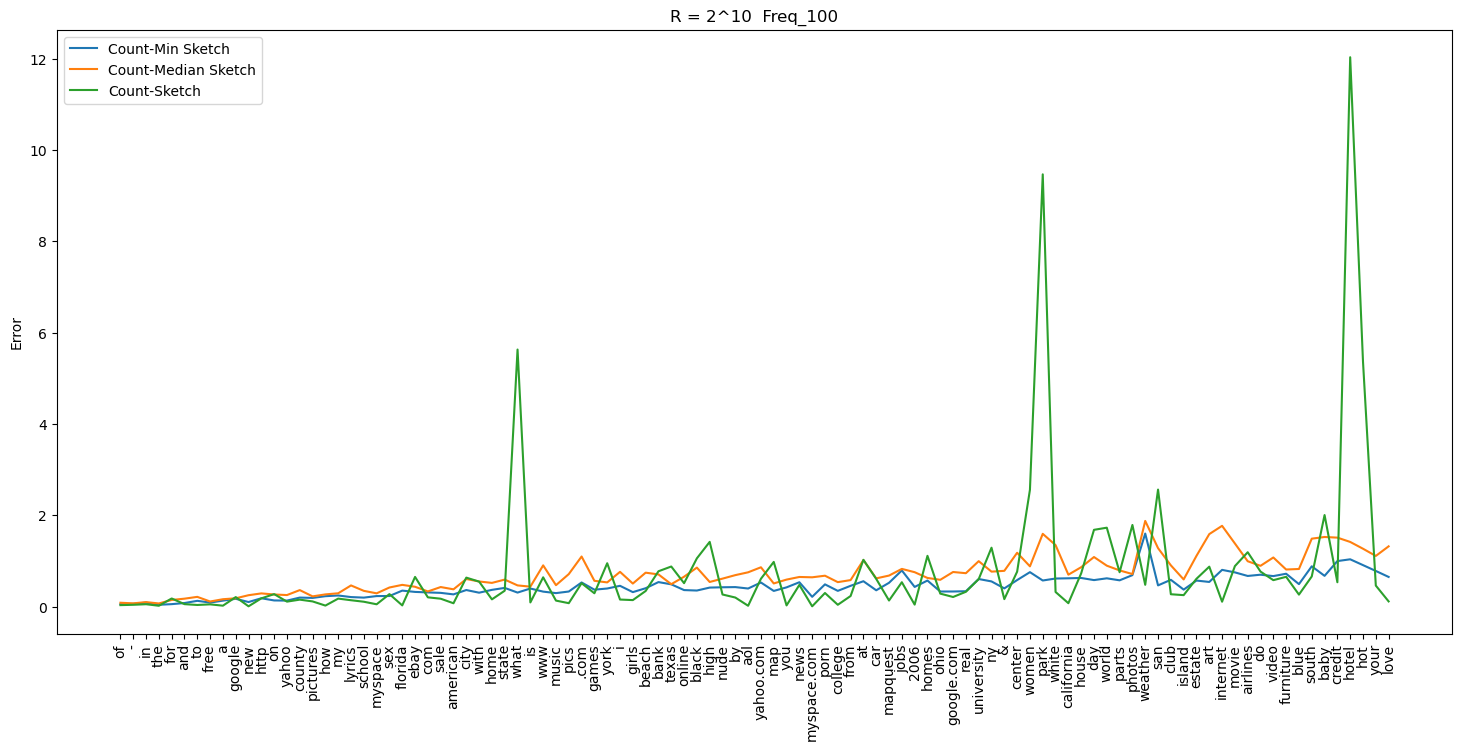

In [52]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_freq_error)
y2 = np.array(cmeds_freq_error)
y3 = np.array(cs_freq_error)
my_xticks = [Freq_100[i][0] for i in range(len(Freq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^10  Freq_100')
plt.legend()
plt.show()

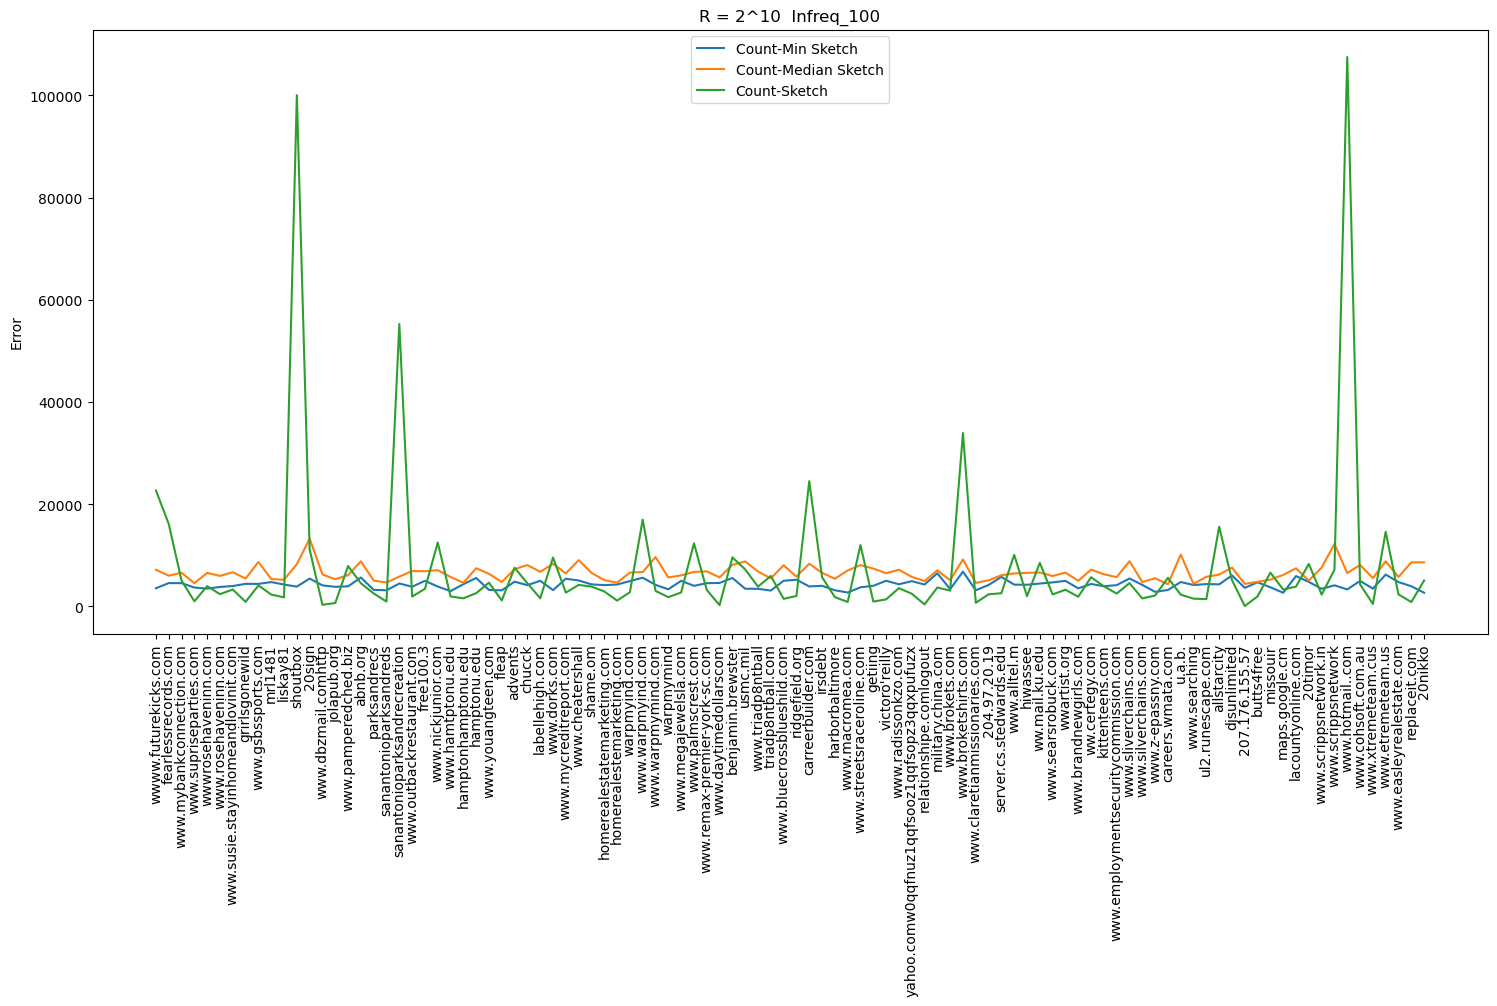

In [53]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_infreq_error)
y2 = np.array(cmeds_infreq_error)
y3 = np.array(cs_infreq_error)
my_xticks = [Infreq_100[i][0] for i in range(len(Infreq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^10  Infreq_100')
plt.legend()
plt.show()

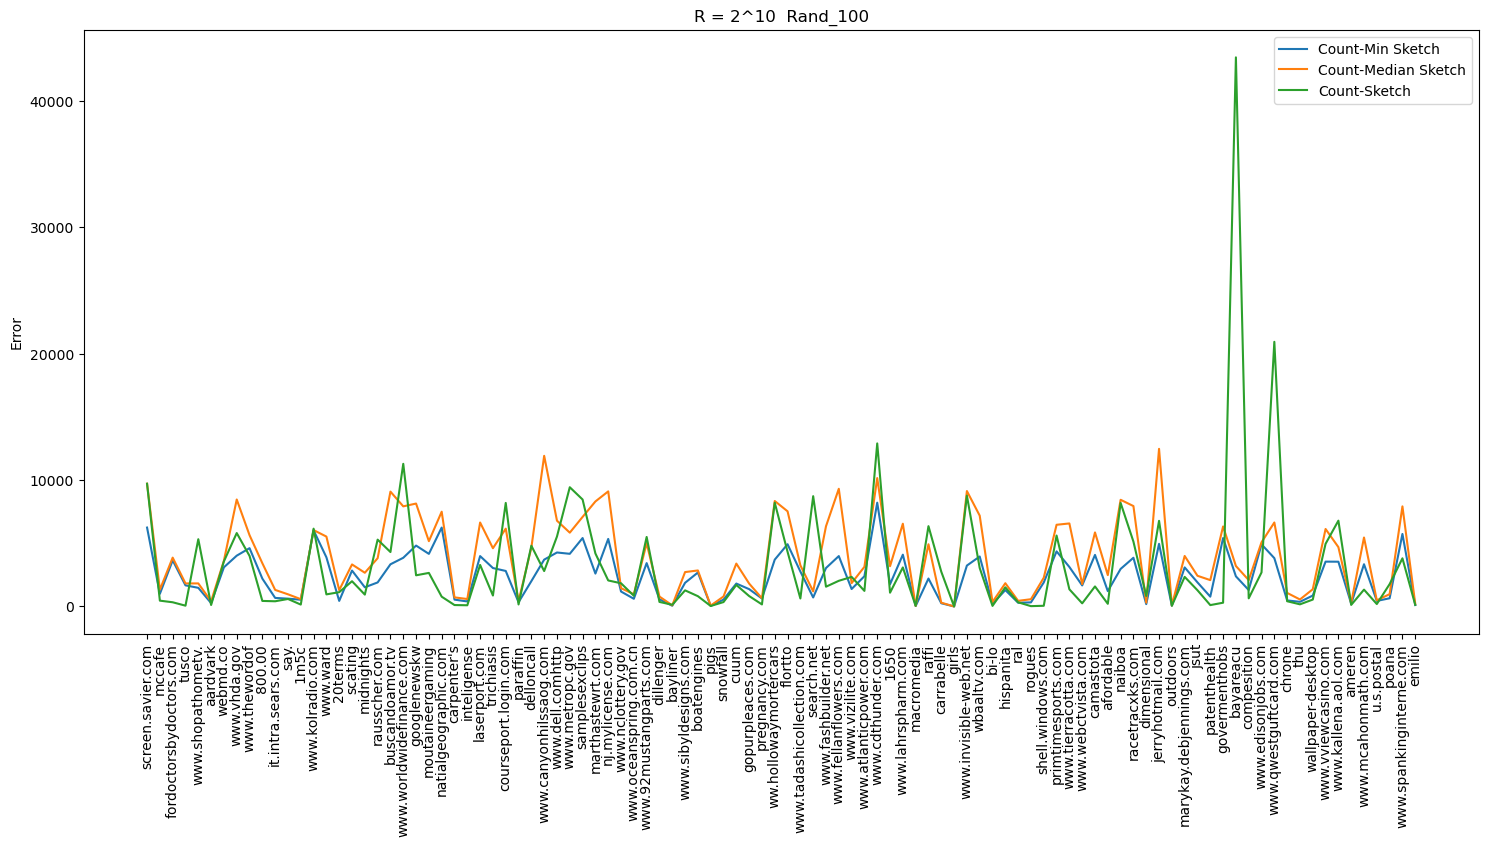

In [54]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_rand_error)
y2 = np.array(cmeds_rand_error)
y3 = np.array(cs_rand_error)
my_xticks = [Rand_100[i][0] for i in range(len(Rand_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^10  Rand_100')
plt.legend()
plt.show()

In [55]:
cms_top500_acc10 = len(set(cms.get_top500().keys()) & set(x[0] for x in Freq_100))
cmeds_top500_acc10 = len(set(cmeds.get_top500().keys()) & set(x[0] for x in Freq_100))
cs_top500_acc10 = len(set(cs.get_top500().keys()) & set(x[0] for x in Freq_100))
print(cms_top500_acc10, cmeds_top500_acc10, cs_top500_acc10)

100 69 79


# R = 2**14

In [56]:
cms = CountMinSketch(R = 2**14)
cmeds = CountMedianSketch(R = 2**14)
cs = CountSketch(R = 2**14)
cnt = 0
for query in querylist:
    for word in query.split():
        cms.insert(word)
        cmeds.insert(word)
        cs.insert(word)
    cnt += 1
    if cnt % 500000 == 0:
        print(cnt)

500000
1000000
1500000
2000000
2500000
3000000
3500000


In [57]:
cms_freq_error, cms_infreq_error, cms_rand_error = [], [], []
cmeds_freq_error, cmeds_infreq_error, cmeds_rand_error = [], [], []
cs_freq_error, cs_infreq_error, cs_rand_error = [], [], []

for elem, cnt in Freq_100:
    cms_freq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_freq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_freq_error.append(abs(cs.query(elem) - cnt)/cnt)

for elem, cnt in Infreq_100:
    cms_infreq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_infreq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_infreq_error.append(abs(cs.query(elem) - cnt)/cnt)
    
for elem, cnt in Rand_100:
    cms_rand_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_rand_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_rand_error.append(abs(cs.query(elem) - cnt)/cnt)

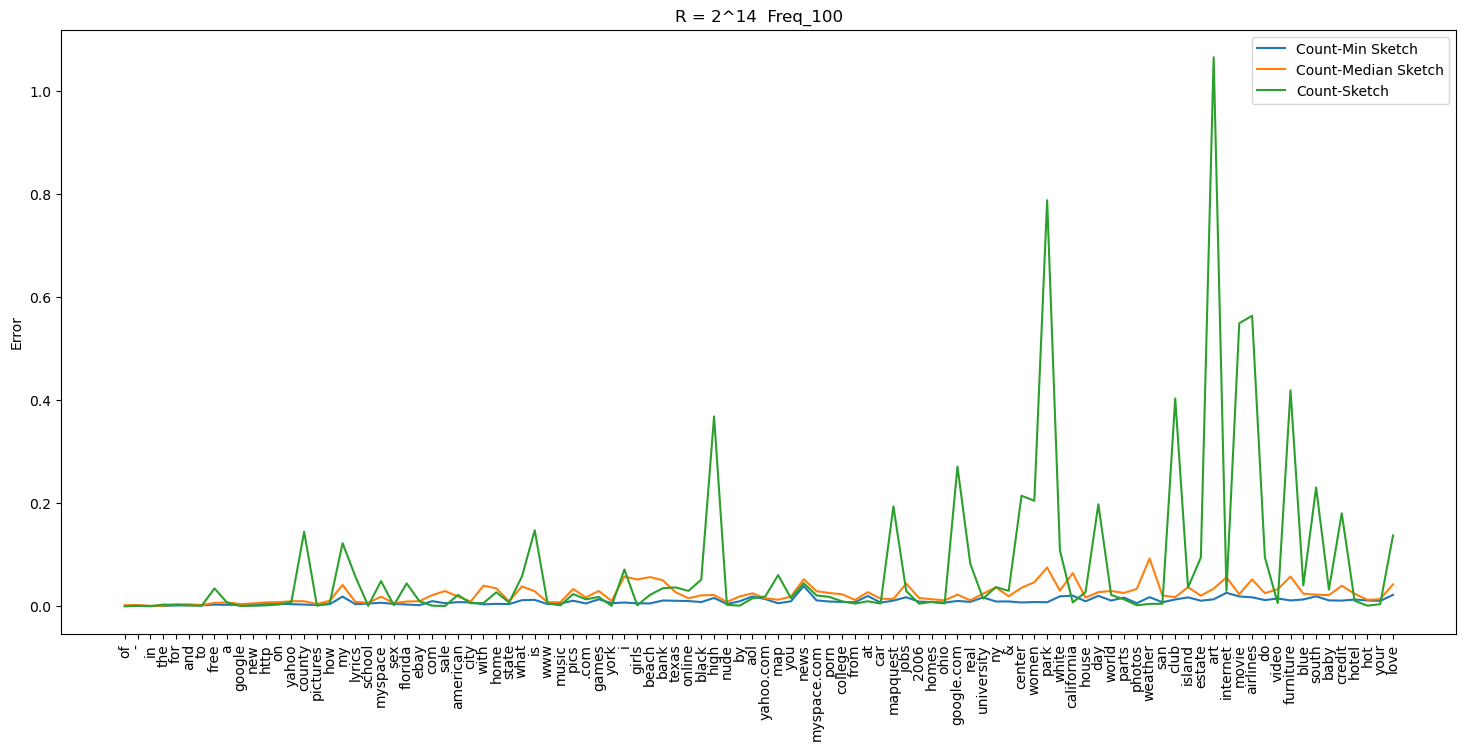

In [58]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_freq_error)
y2 = np.array(cmeds_freq_error)
y3 = np.array(cs_freq_error)
my_xticks = [Freq_100[i][0] for i in range(len(Freq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^14  Freq_100')
plt.legend()
plt.show()

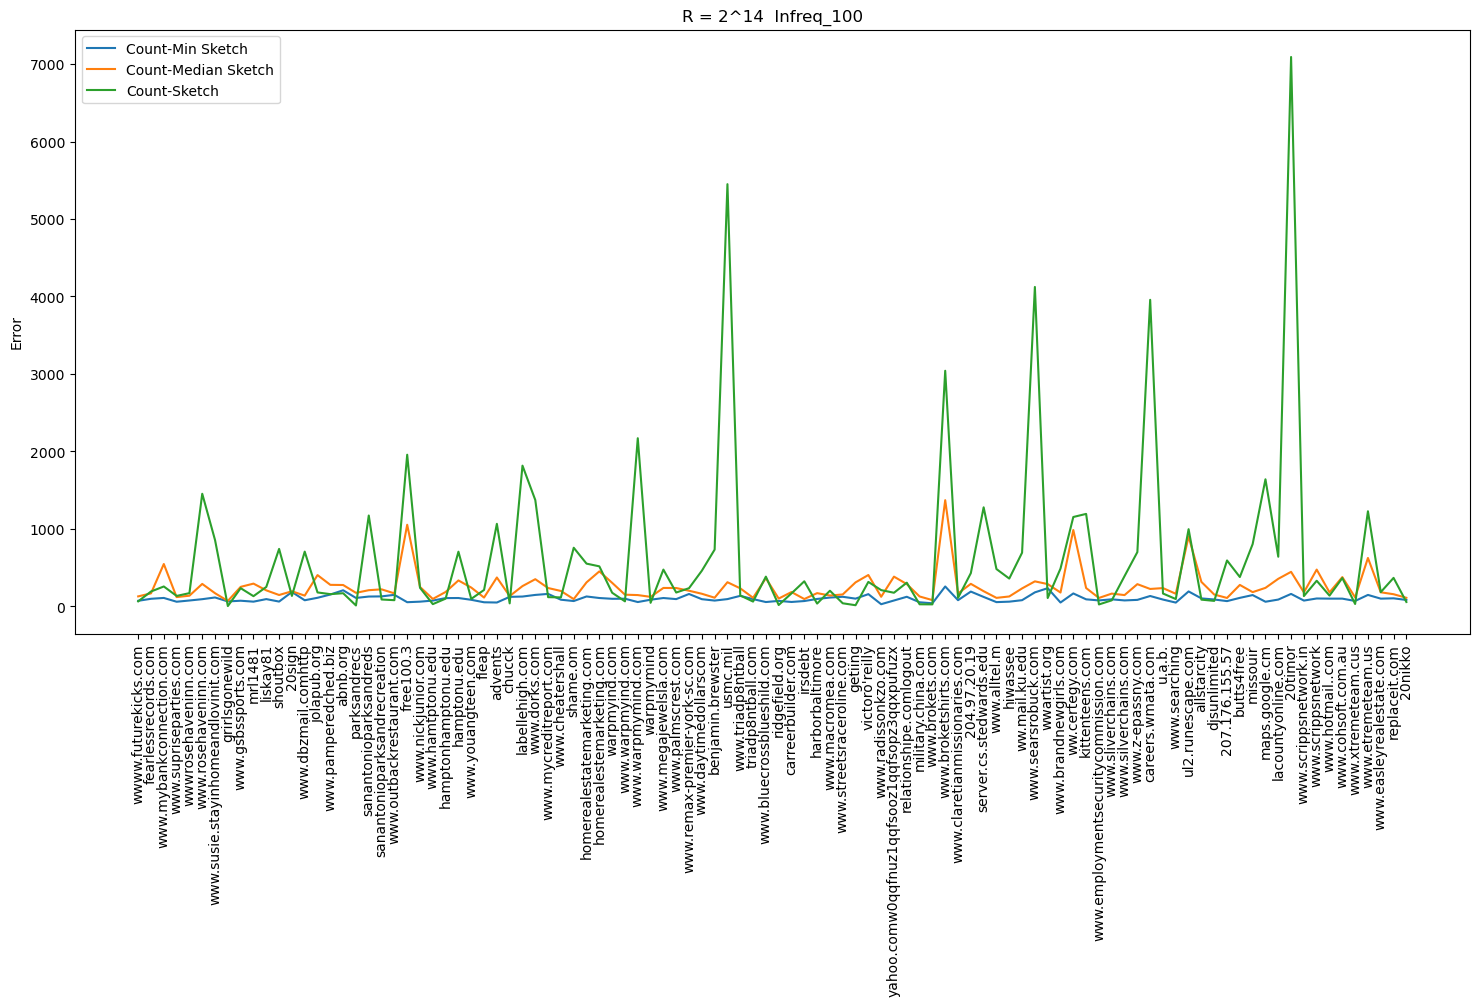

In [59]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_infreq_error)
y2 = np.array(cmeds_infreq_error)
y3 = np.array(cs_infreq_error)
my_xticks = [Infreq_100[i][0] for i in range(len(Infreq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^14  Infreq_100')
plt.legend()
plt.show()

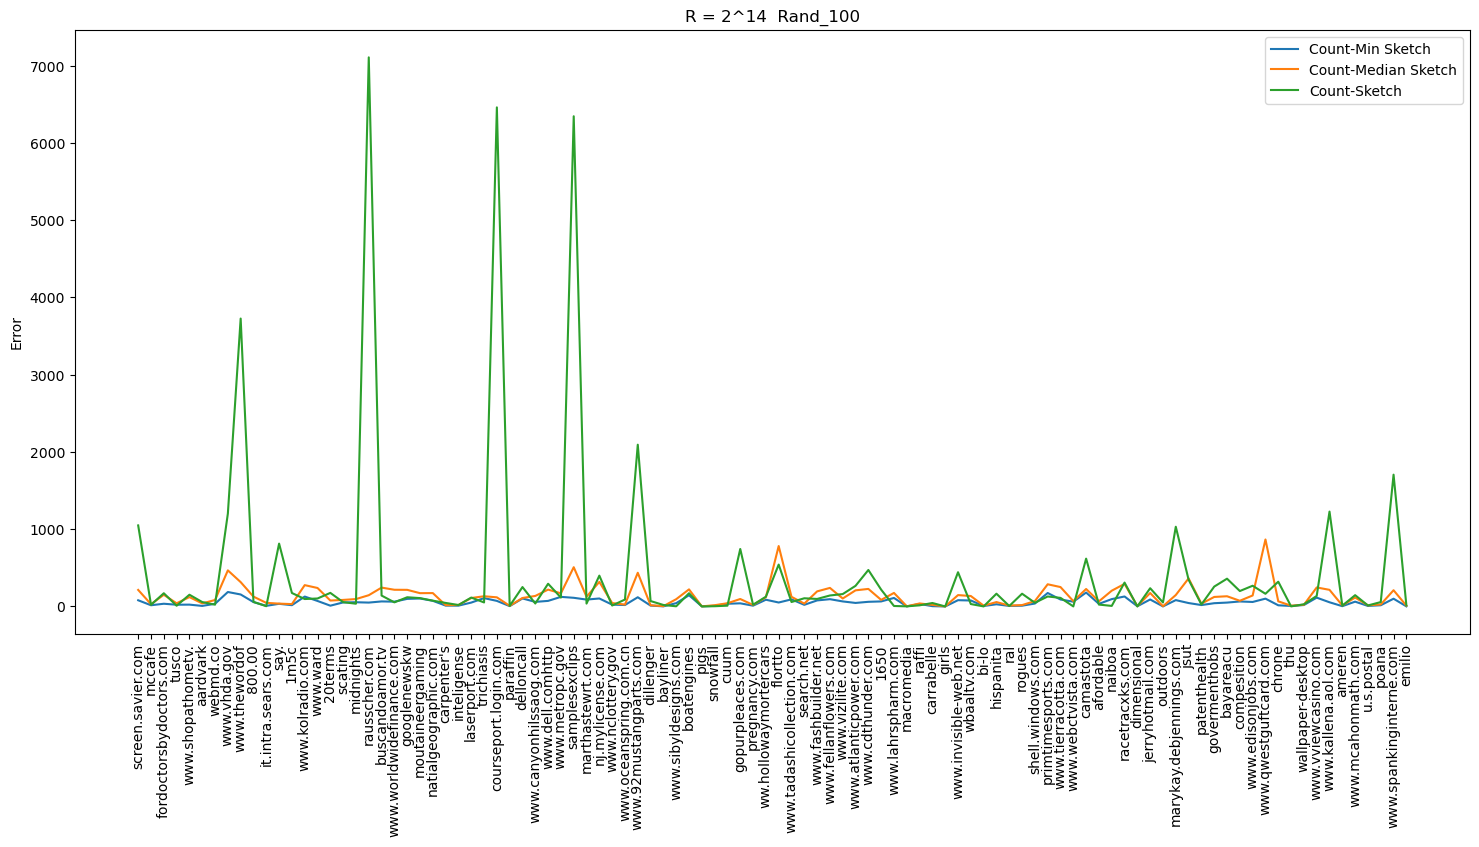

In [60]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_rand_error)
y2 = np.array(cmeds_rand_error)
y3 = np.array(cs_rand_error)
my_xticks = [Rand_100[i][0] for i in range(len(Rand_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^14  Rand_100')
plt.legend()
plt.show()

In [61]:
cms_top500_acc14 = len(set(cms.get_top500().keys()) & set(x[0] for x in Freq_100))
cmeds_top500_acc14 = len(set(cmeds.get_top500().keys()) & set(x[0] for x in Freq_100))
cs_top500_acc14 = len(set(cs.get_top500().keys()) & set(x[0] for x in Freq_100))
print(cms_top500_acc14, cmeds_top500_acc14, cs_top500_acc14)

100 100 98


# R = 2**18

In [62]:
cms = CountMinSketch(R = 2**18)
cmeds = CountMedianSketch(R = 2**18)
cs = CountSketch(R = 2**18)
cnt = 0
for query in querylist:
    for word in query.split():
        cms.insert(word)
        cmeds.insert(word)
        cs.insert(word)
    cnt += 1
    if cnt % 500000 == 0:
        print(cnt)

500000
1000000
1500000
2000000
2500000
3000000
3500000


In [63]:
cms_freq_error, cms_infreq_error, cms_rand_error = [], [], []
cmeds_freq_error, cmeds_infreq_error, cmeds_rand_error = [], [], []
cs_freq_error, cs_infreq_error, cs_rand_error = [], [], []

for elem, cnt in Freq_100:
    cms_freq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_freq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_freq_error.append(abs(cs.query(elem) - cnt)/cnt)

for elem, cnt in Infreq_100:
    cms_infreq_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_infreq_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_infreq_error.append(abs(cs.query(elem) - cnt)/cnt)
    
for elem, cnt in Rand_100:
    cms_rand_error.append(abs(cms.query(elem) - cnt)/cnt)
    cmeds_rand_error.append(abs(cmeds.query(elem) - cnt)/cnt)
    cs_rand_error.append(abs(cs.query(elem) - cnt)/cnt)

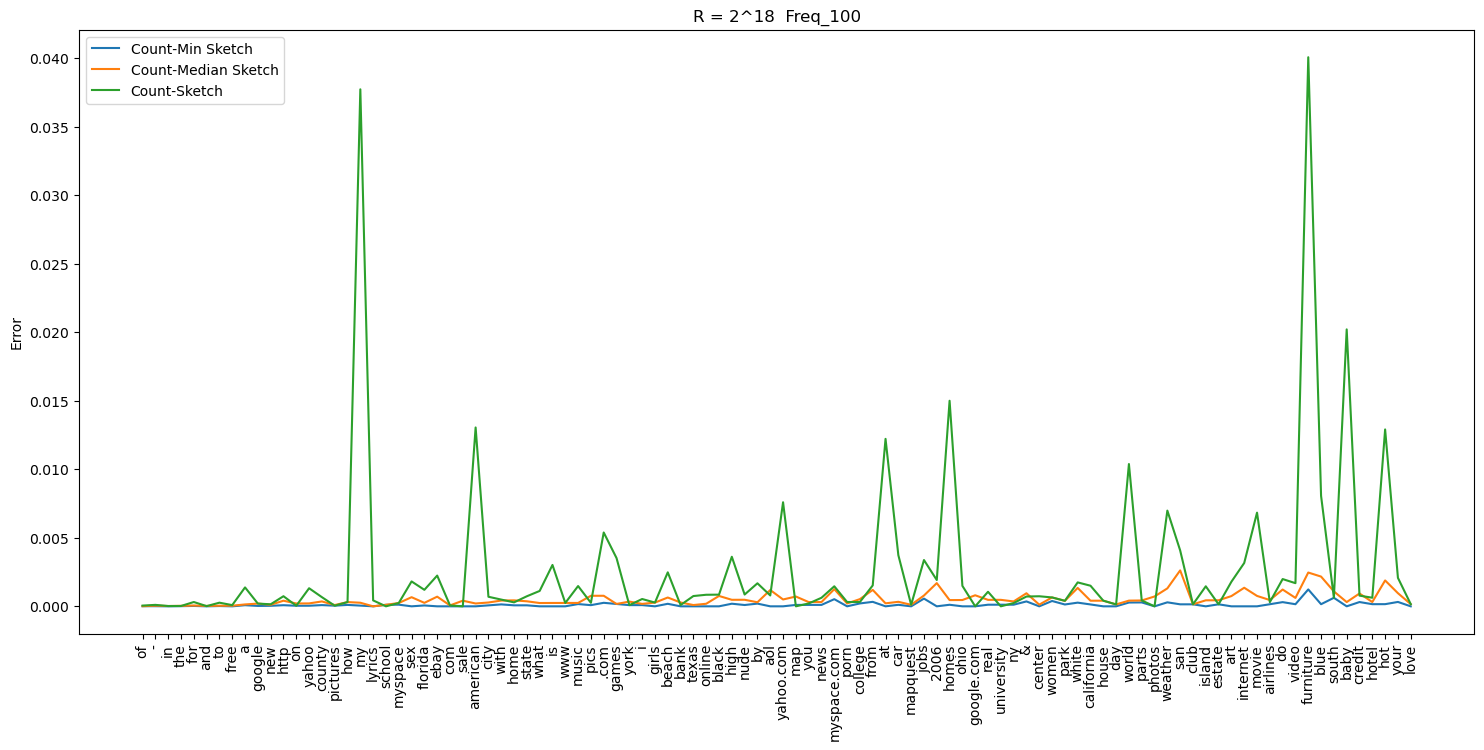

In [64]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_freq_error)
y2 = np.array(cmeds_freq_error)
y3 = np.array(cs_freq_error)
my_xticks = [Freq_100[i][0] for i in range(len(Freq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^18  Freq_100')
plt.legend()
plt.show()

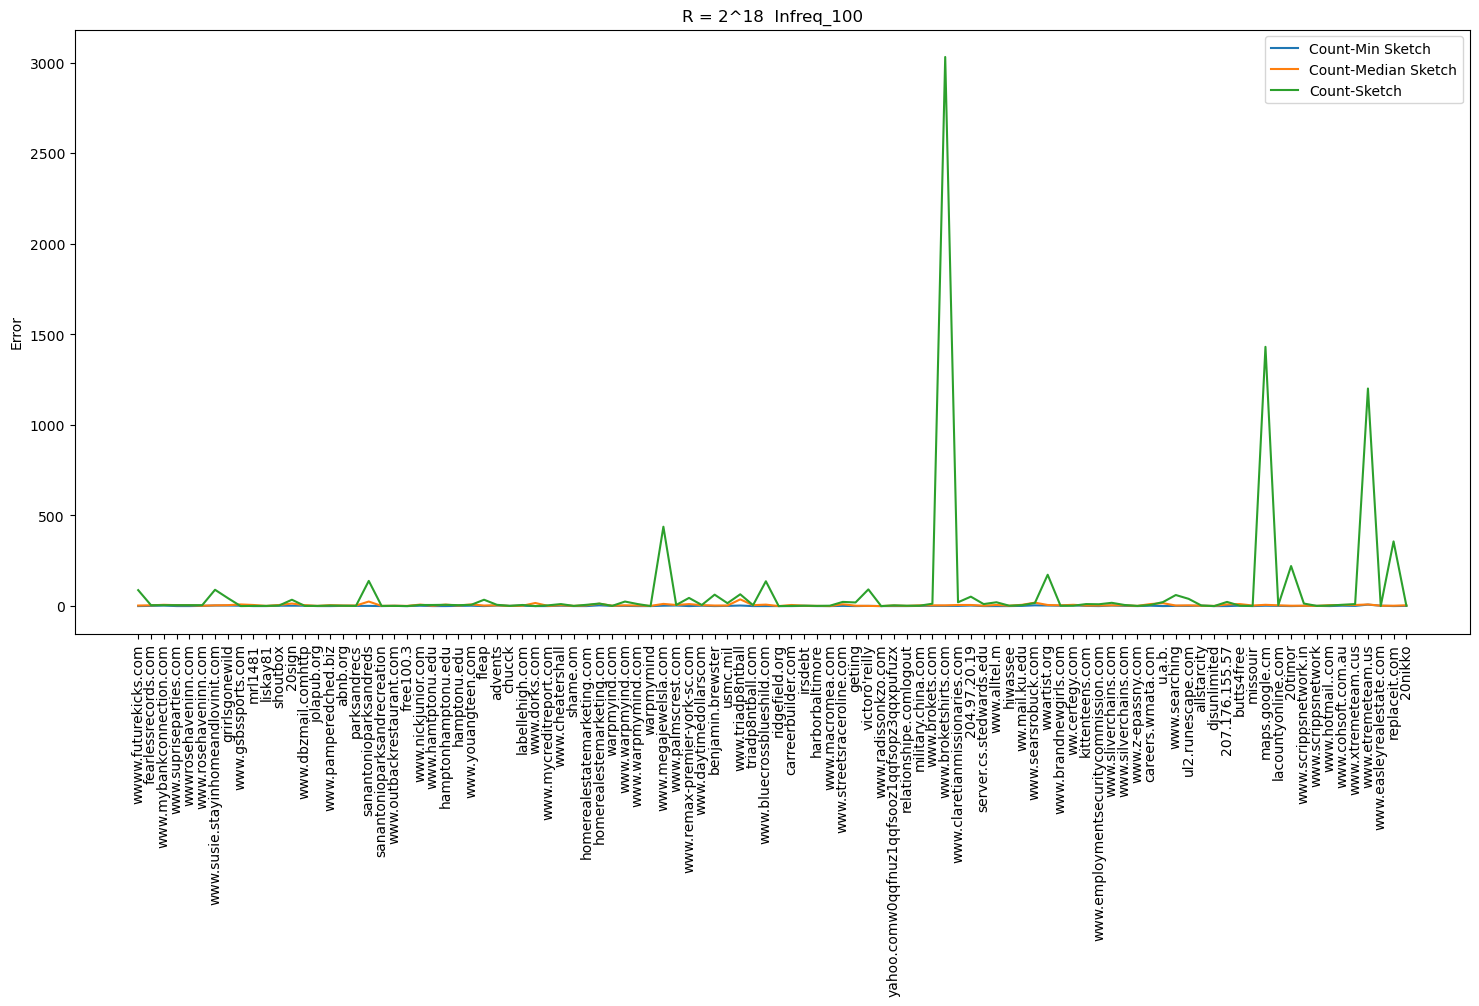

In [65]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_infreq_error)
y2 = np.array(cmeds_infreq_error)
y3 = np.array(cs_infreq_error)
my_xticks = [Infreq_100[i][0] for i in range(len(Infreq_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^18  Infreq_100')
plt.legend()
plt.show()

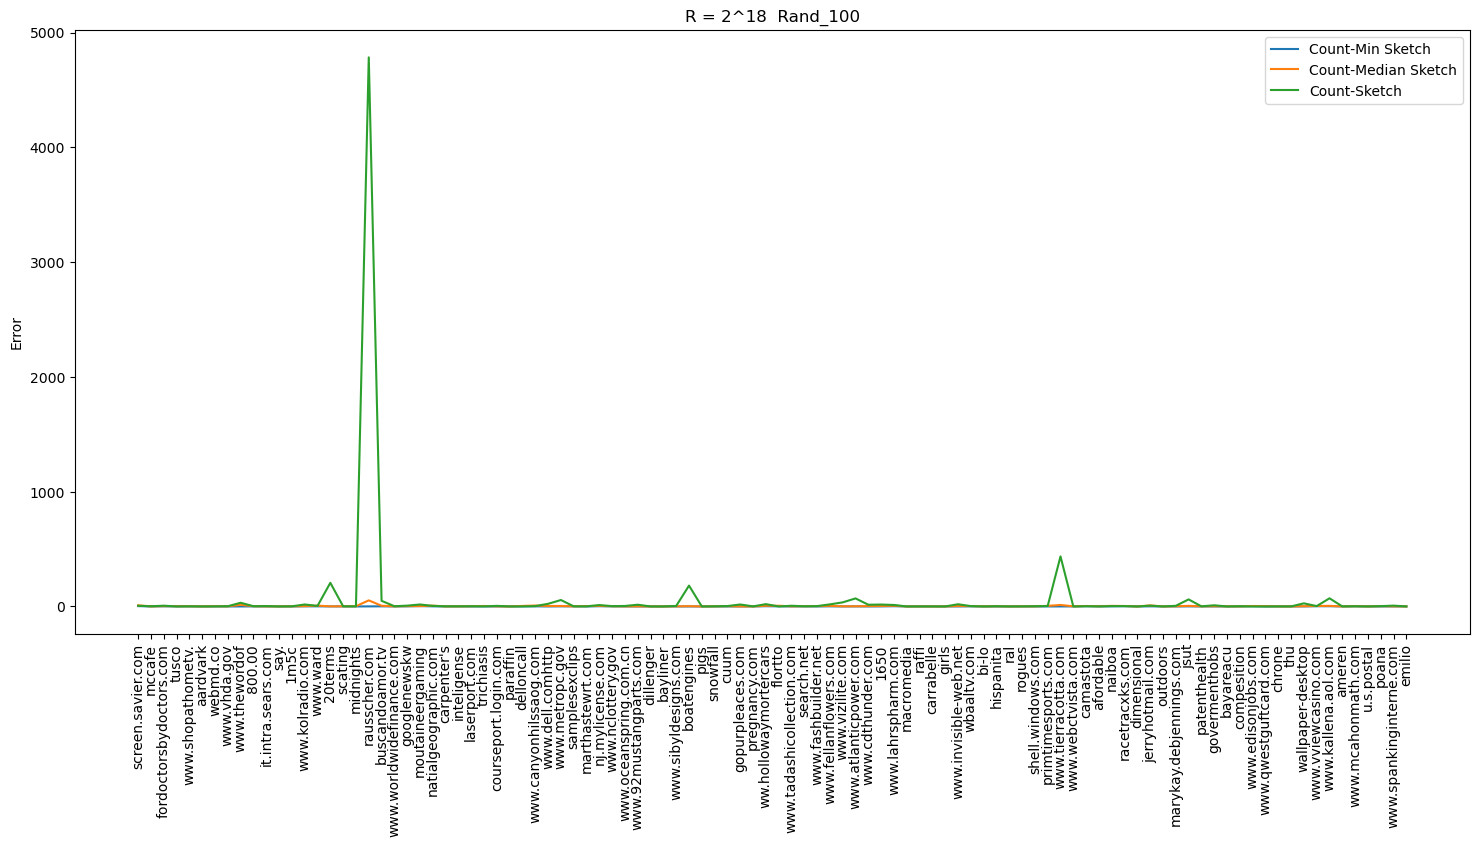

In [66]:
x = np.arange(0, 100, 1)
y1 = np.array(cms_rand_error)
y2 = np.array(cmeds_rand_error)
y3 = np.array(cs_rand_error)
my_xticks = [Rand_100[i][0] for i in range(len(Rand_100))]
plt.figure(figsize=(18, 8), dpi = 100)
plt.xticks(x, my_xticks, rotation='vertical')
plt.plot(x, y1, label = 'Count-Min Sketch')
plt.plot(x, y2, label = 'Count-Median Sketch')
plt.plot(x, y3, label = 'Count-Sketch')
plt.ylabel('Error')
plt.title('R = 2^18  Rand_100')
plt.legend()
plt.show()

In [67]:
cms_top500_acc18 = len(set(cms.get_top500().keys()) & set(x[0] for x in Freq_100))
cmeds_top500_acc18 = len(set(cmeds.get_top500().keys()) & set(x[0] for x in Freq_100))
cs_top500_acc18 = len(set(cs.get_top500().keys()) & set(x[0] for x in Freq_100))
print(cms_top500_acc18, cmeds_top500_acc18, cs_top500_acc18)

100 100 100


# Sketches with Heaps

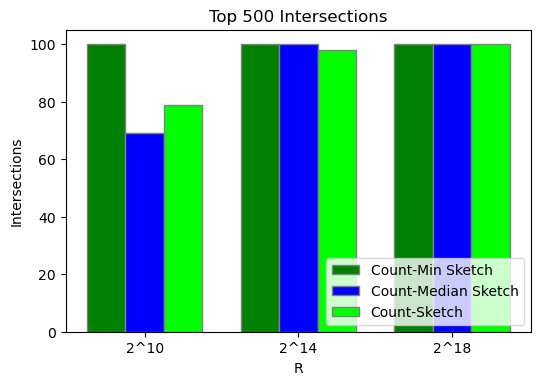

In [68]:
cms_top500_acc = [cms_top500_acc10] + [cms_top500_acc14] + [cms_top500_acc18]
cmeds_top500_acc = [cmeds_top500_acc10] + [cmeds_top500_acc14] + [cmeds_top500_acc18]
cs_top500_acc = [cs_top500_acc10] + [cs_top500_acc14] + [cs_top500_acc18]

x = np.arange(0, 3, 1)
y1 = np.array(cms_top500_acc)
y2 = np.array(cmeds_top500_acc)
y3 = np.array(cs_top500_acc)
my_xticks = ['2^10', '2^14', '2^18']
barWidth = 0.25


plt.figure(figsize=(6, 4), dpi = 100)

# Set position of bar on X axis
br1 = np.arange(len(y1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, y1, color ='green', width = barWidth,
        edgecolor ='grey', label ='Count-Min Sketch')
plt.bar(br2, y2, color ='blue', width = barWidth,
        edgecolor ='grey', label ='Count-Median Sketch')
plt.bar(br3, y3, color ='lime', width = barWidth,
        edgecolor ='grey', label ='Count-Sketch')
 
# Adding Xticks
plt.xlabel('R')
plt.ylabel('Intersections')
plt.xticks([r + barWidth for r in range(len(y1))],
        ['2^10', '2^14', '2^18'])
plt.title('Top 500 Intersections') 
plt.legend(loc = 'lower right')
plt.show()